In [82]:
import json

with open("location-history.json", "r") as f:
    data = json.load(f)

print("Total entries:", len(data))


Total entries: 561


In [83]:
from datetime import datetime

start_times = []
end_times = []

for entry in data:
    if "startTime" in entry and "endTime" in entry:
        start_times.append(datetime.fromisoformat(entry["startTime"]))
        end_times.append(datetime.fromisoformat(entry["endTime"]))

if start_times and end_times:
    overall_start = min(start_times)
    overall_end = max(end_times)
    print("Data starts at:", overall_start)
    print("Data ends at:", overall_end)


Data starts at: 2025-02-12 01:00:00+00:00
Data ends at: 2025-03-27 12:41:16.700000-04:00


In [84]:
import datetime

def parse_location_string(loc_str):
    # Remove the "geo:" prefix and split by comma
    try:
        _, coords = loc_str.split("geo:")
    except ValueError:
        coords = loc_str.replace("geo:", "")
    lat, lng = coords.split(",")
    return float(lat), float(lng)

visits = []
for entry in data:
    # Only interested in entries that have a 'visit' field.
    if "visit" in entry:
        try:
            candidate = entry["visit"]["topCandidate"]
            loc_str = candidate["placeLocation"]
            lat, lng = parse_location_string(loc_str)

            start = datetime.datetime.fromisoformat(entry["startTime"])
            end = datetime.datetime.fromisoformat(entry["endTime"])
            duration = (end - start).total_seconds()  # in seconds

            visits.append({
                "lat": lat,
                "lng": lng,
                "start": start,
                "end": end,
                "duration": duration
            })
        except Exception as e:
            # If any key is missing, skip the entry
            continue

print("Total visits extracted:", len(visits))


Total visits extracted: 217


# Clustering Data

In [85]:
import numpy as np
from sklearn.cluster import DBSCAN

# Convert visits to an array of [lat, lng] and then to radians
coords = np.array([[visit["lat"], visit["lng"]] for visit in visits])
coords_rad = np.radians(coords)

# Define DBSCAN parameters:
# eps: maximum distance (in radians).
eps = 100 / 6371000  # 100 meters in radians.
min_samples = 3      # require at least 3 visits to form a cluster

db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(coords_rad)
labels = db.labels_

# Add the cluster labels to each visit.
for i, visit in enumerate(visits):
    visit["cluster"] = labels[i]

# Count clusters (excluding noise points, which are labeled as -1)
unique_clusters = set(labels)
if -1 in unique_clusters:
    unique_clusters.remove(-1)
print("Number of significant clusters (excluding noise):", len(unique_clusters))


Number of significant clusters (excluding noise): 15


In [86]:
from collections import defaultdict

cluster_info = defaultdict(lambda: {"lat_sum": 0, "lng_sum": 0, "total_duration": 0, "count": 0})
for visit in visits:
    cluster = visit["cluster"]
    # Only consider clusters (ignore noise)
    if cluster == -1:
        continue
    cluster_info[cluster]["lat_sum"] += visit["lat"]
    cluster_info[cluster]["lng_sum"] += visit["lng"]
    cluster_info[cluster]["total_duration"] += visit["duration"]
    cluster_info[cluster]["count"] += 1

# Compute centroid for each cluster
for cluster, info in cluster_info.items():
    info["centroid"] = (info["lat_sum"] / info["count"], info["lng_sum"] / info["count"])

# Print summary for each cluster
for cluster, info in cluster_info.items():
    hours = info["total_duration"] / 3600
    print(f"Cluster {cluster}: {info['count']} visits, total duration ~ {hours:.2f} hrs, centroid: {info['centroid']}")


Cluster 0: 47 visits, total duration ~ 572.40 hrs, centroid: (38.030823000000034, -78.50873700000007)
Cluster 1: 17 visits, total duration ~ 48.98 hrs, centroid: (38.03355299999999, -78.507977)
Cluster 2: 9 visits, total duration ~ 3.24 hrs, centroid: (38.055007999999994, -78.496939)
Cluster 3: 9 visits, total duration ~ 35.36 hrs, centroid: (38.032187, -78.493222)
Cluster 4: 4 visits, total duration ~ 1.50 hrs, centroid: (38.052815, -78.501257)
Cluster 5: 5 visits, total duration ~ 6.85 hrs, centroid: (38.031619, -78.510846)
Cluster 6: 10 visits, total duration ~ 10.45 hrs, centroid: (38.032881999999994, -78.513558)
Cluster 7: 18 visits, total duration ~ 159.62 hrs, centroid: (37.687814, -77.60276799999998)
Cluster 8: 3 visits, total duration ~ 1.54 hrs, centroid: (37.656101, -77.618943)
Cluster 9: 4 visits, total duration ~ 6.17 hrs, centroid: (37.668375, -77.612032)
Cluster 10: 4 visits, total duration ~ 1.67 hrs, centroid: (37.650861500000005, -77.604527)
Cluster 11: 8 visits, tota

# Determining Location Data Manually

In [87]:
# Define the manual mapping for clusters 0 through 11.
manual_mapping = {
    0: "1707 Jefferson Park Avenue",
    1: "Thornton Hall",
    2: "Cook Out",
    3: "The Flats",
    4: "Harris Teeter / Barracks Road Shopping Center",
    5: "Rice Hall",
    6: "Aquatic Fitness Center",
    7: "Home",
    8: "Short Pump Town Center",
    9: "Pouncey Tract Park Pickleball Courts",
    10: "McDonald's",
    11: "The Bellagio"
}

# Filter out clusters 12, 13, and 14
filtered_cluster_info = {k: v for k, v in cluster_info.items() if k in manual_mapping}

# Add the manual labels to each remaining cluster.
for cluster, info in filtered_cluster_info.items():
    info["manual_label"] = manual_mapping[cluster]

# Print a summary for each cluster (now only clusters 0 through 11)
for cluster, info in filtered_cluster_info.items():
    hours = info["total_duration"] / 3600
    print(f"Cluster {cluster}: {info['count']} visits, total duration ~ {hours:.2f} hrs, centroid: {info['centroid']}")
    print(f"  -> Label: {info['manual_label']}")


Cluster 0: 47 visits, total duration ~ 572.40 hrs, centroid: (38.030823000000034, -78.50873700000007)
  -> Label: 1707 Jefferson Park Avenue
Cluster 1: 17 visits, total duration ~ 48.98 hrs, centroid: (38.03355299999999, -78.507977)
  -> Label: Thornton Hall
Cluster 2: 9 visits, total duration ~ 3.24 hrs, centroid: (38.055007999999994, -78.496939)
  -> Label: Cook Out
Cluster 3: 9 visits, total duration ~ 35.36 hrs, centroid: (38.032187, -78.493222)
  -> Label: The Flats
Cluster 4: 4 visits, total duration ~ 1.50 hrs, centroid: (38.052815, -78.501257)
  -> Label: Harris Teeter / Barracks Road Shopping Center
Cluster 5: 5 visits, total duration ~ 6.85 hrs, centroid: (38.031619, -78.510846)
  -> Label: Rice Hall
Cluster 6: 10 visits, total duration ~ 10.45 hrs, centroid: (38.032881999999994, -78.513558)
  -> Label: Aquatic Fitness Center
Cluster 7: 18 visits, total duration ~ 159.62 hrs, centroid: (37.687814, -77.60276799999998)
  -> Label: Home
Cluster 8: 3 visits, total duration ~ 1.54

# Plotting Location Data

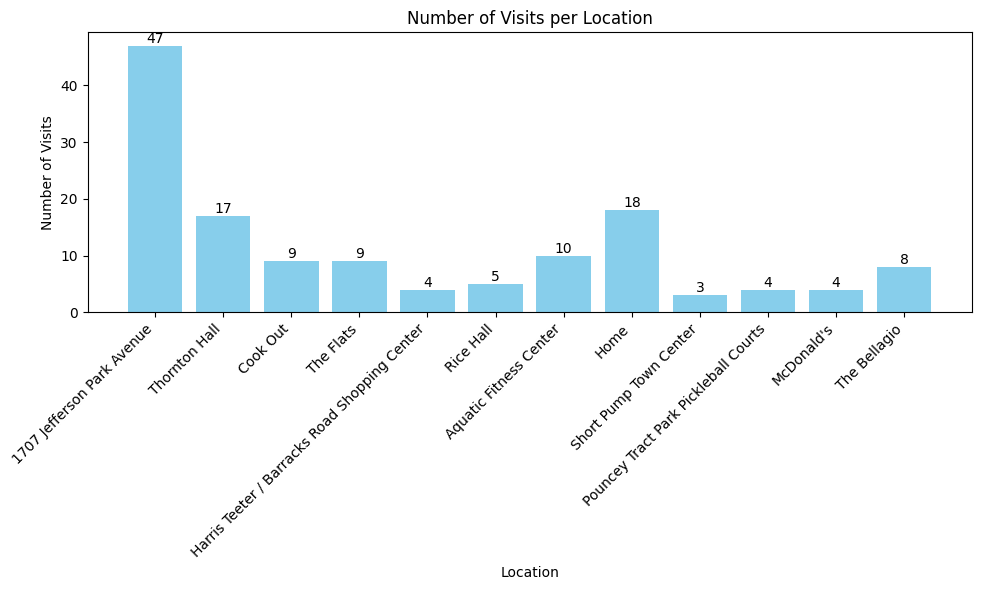

In [88]:
import matplotlib.pyplot as plt

# Prepare data for bar plots from the filtered_cluster_info dictionary.
locations = []
num_visits = []
total_duration_hours = []

for cluster, info in filtered_cluster_info.items():
    locations.append(info["manual_label"])
    num_visits.append(info["count"])
    total_duration_hours.append(info["total_duration"] / 3600)  # Convert seconds to hours

# Plot 1: Number of visits per location
plt.figure(figsize=(10, 6))
bars = plt.bar(locations, num_visits, color='skyblue')
plt.xlabel("Location")
plt.ylabel("Number of Visits")
plt.title("Number of Visits per Location")
plt.xticks(rotation=45, ha='right')

# Annotate each bar with its corresponding number of visits
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()



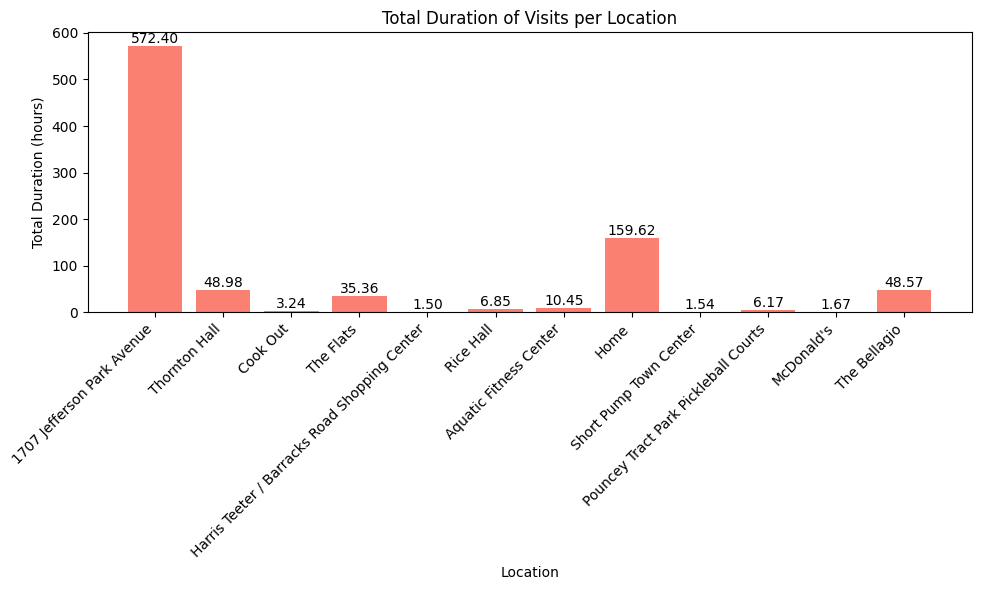

In [89]:
# Plot 2: Total duration of visits per location (in hours)
plt.figure(figsize=(10, 6))
bars = plt.bar(locations, total_duration_hours, color='salmon')
plt.xlabel("Location")
plt.ylabel("Total Duration (hours)")
plt.title("Total Duration of Visits per Location")
plt.xticks(rotation=45, ha='right')

# Annotate each bar with its corresponding duration (formatted to 2 decimal places)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Determing Location Data with Foursquare

In [90]:
import requests, math

FOURSQUARE_API_KEY = "fsq30K25LYK6zMlZ4tCaiHTVxjf+t3TcE29kP5yrs5pcxME="

def haversine(lat1, lng1, lat2, lng2):
    """Compute the distance (in meters) between two points using the haversine formula."""
    R = 6371000  # Earth radius in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lng2 - lng1)
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

def search_foursquare(lat, lng, radius=200, limit=10):
    """
    Uses Foursquare's Places Search endpoint to retrieve nearby candidates.
    """
    url = "https://api.foursquare.com/v3/places/search"
    headers = {
        "Accept": "application/json",
        "Authorization": FOURSQUARE_API_KEY
    }
    params = {
        "ll": f"{lat},{lng}",
        "radius": radius,
        "limit": limit
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json().get("results", [])
    else:
        print("Error with Foursquare Search:", response.status_code, response.text)
        return []

def get_closest_candidate(cluster_centroid, candidates):
    """Given a list of candidate places, return the candidate with the smallest geographic distance."""
    nearest = None
    nearest_distance = float("inf")
    for candidate in candidates:
        # Foursquare returns geocode coordinates under candidate["geocodes"]["main"]
        candidate_lat = candidate.get("geocodes", {}).get("main", {}).get("latitude")
        candidate_lng = candidate.get("geocodes", {}).get("main", {}).get("longitude")
        if candidate_lat is not None and candidate_lng is not None:
            distance = haversine(cluster_centroid[0], cluster_centroid[1], candidate_lat, candidate_lng)
            if distance < nearest_distance:
                nearest_distance = distance
                nearest = candidate
    return nearest, nearest_distance

def label_location(candidate):
    """
    Automatically assign a label to a location based on its Foursquare category names.
    This heuristic uses simple keyword matching.
    """
    if not candidate:
        return "Unknown"

    categories = candidate.get("categories", [])
    # Define a simple mapping from keywords to desired labels
    mapping = {
        "Home": ["residence", "home"],
        "Restaurant": ["restaurant", "cafe", "diner", "eatery", "bistro"],
        "Office": ["office", "work", "business"],
        "School": ["university", "college", "school"],
        "Shopping": ["mall", "store", "shopping", "market"],
        "Park": ["park", "garden"],
        "Gym": ["fitness", "gym", "health", "sport"],
        "Transit": ["station", "transit", "bus", "train"],
        "Entertainment": ["cinema", "theater", "concert", "bar", "pub"],
    }

    # Gather all category names (convert to lower case)
    cat_names = [cat.get("name", "").lower() for cat in categories]

    for label, keywords in mapping.items():
        for keyword in keywords:
            if any(keyword in cat for cat in cat_names):
                return label
    # If no keywords match, default to "Other"
    return "Other"

for cluster, info in filtered_cluster_info.items():
    centroid = info["centroid"]
    print(f"\nCluster {cluster} at centroid: {centroid}")
    candidates = search_foursquare(centroid[0], centroid[1], radius=200, limit=10)
    if candidates:
        closest, distance = get_closest_candidate(centroid, candidates)
        if closest:
            # Print out details about the chosen candidate
            name = closest.get("name", "Unknown")
            location = closest.get("location", {})
            address = location.get("formatted_address", "No address provided")
            assigned_label = label_location(closest)
            print(f"Closest candidate: {name}")
            print(f"  Address: {address}")
            print(f"  Auto-assigned label: {assigned_label}")
            info["foursquare_candidate"] = closest
            info["auto_label"] = assigned_label
        else:
            print("No candidate with valid location info found.")
    else:
        name = "Home"
        location = closest.get("location", {})
        address = ""
        assigned_label = "Home"
        print(f"Closest candidate: {name}")
        print(f"  Address: {address}")
        print(f"  Auto-assigned label: {assigned_label}")




Cluster 0 at centroid: (38.030823000000034, -78.50873700000007)
Closest candidate: Home
  Address: 
  Auto-assigned label: Home

Cluster 1 at centroid: (38.03355299999999, -78.507977)
Closest candidate: University Of Va Department Of Electrical Computer Engineering Charlottesville
  Address: 351 McCormick Rd, Charlottesville, VA 22904
  Auto-assigned label: Other

Cluster 2 at centroid: (38.055007999999994, -78.496939)
Closest candidate: Cookout
  Address: 1254 Emmet St N, Charlottesville, VA 22903
  Auto-assigned label: Restaurant

Cluster 3 at centroid: (38.032187, -78.493222)
Closest candidate: Benny Deluca's
  Address: 913 W Main St, Charlottesville, VA 22903
  Auto-assigned label: Restaurant

Cluster 4 at centroid: (38.052815, -78.501257)
Closest candidate: Rebecca's Natural Food
  Address: 1141 Emmet St N (Barracks Road Shopping Center), Charlottesville, VA 22903
  Auto-assigned label: Shopping

Cluster 5 at centroid: (38.031619, -78.510846)
Closest candidate: University Of Va D

# Plotting Foursquare Location Data

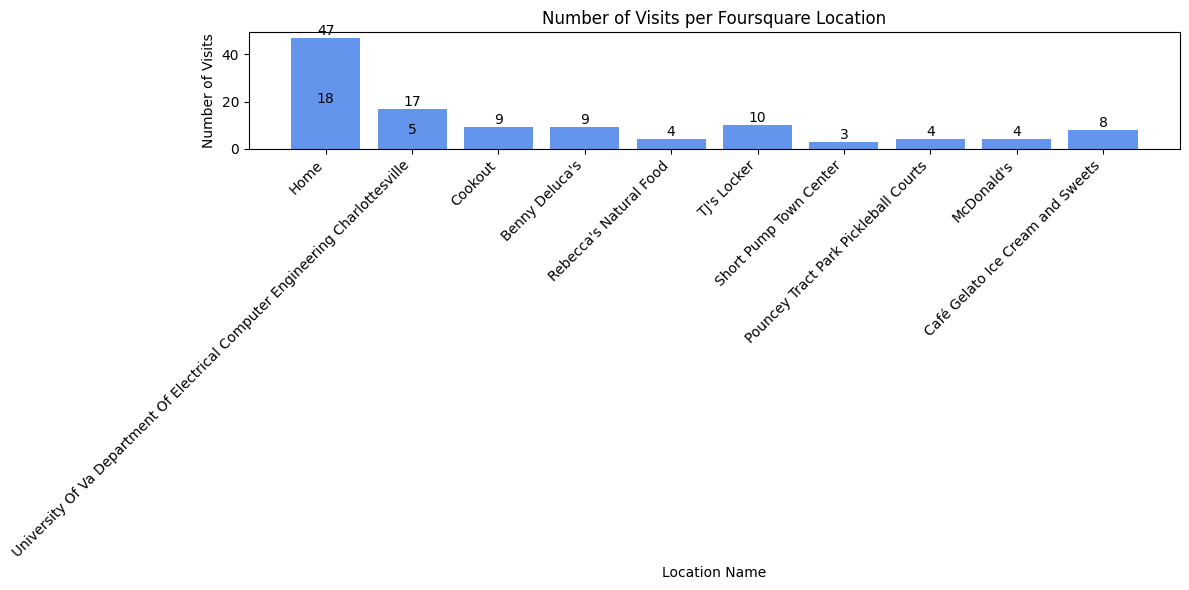

In [91]:
import matplotlib.pyplot as plt

# Create lists for location names and their visit counts.
location_names = []
visit_counts = []

for cluster, info in filtered_cluster_info.items():
    # Get the candidate from Foursquare
    candidate = info.get("foursquare_candidate", {})
    # Use the candidate name
    name = candidate.get("name", "Home")
    # Use the visit count from your cluster info (assumed stored as "count")
    count = info.get("count", 0)

    location_names.append(name)
    visit_counts.append(count)

# Create a bar plot of number of visits per location.
plt.figure(figsize=(12, 6))
bars = plt.bar(location_names, visit_counts, color='cornflowerblue')
plt.xlabel("Location Name")
plt.ylabel("Number of Visits")
plt.title("Number of Visits per Foursquare Location")
plt.xticks(rotation=45, ha="right")

# Annotate each bar with the visit count.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


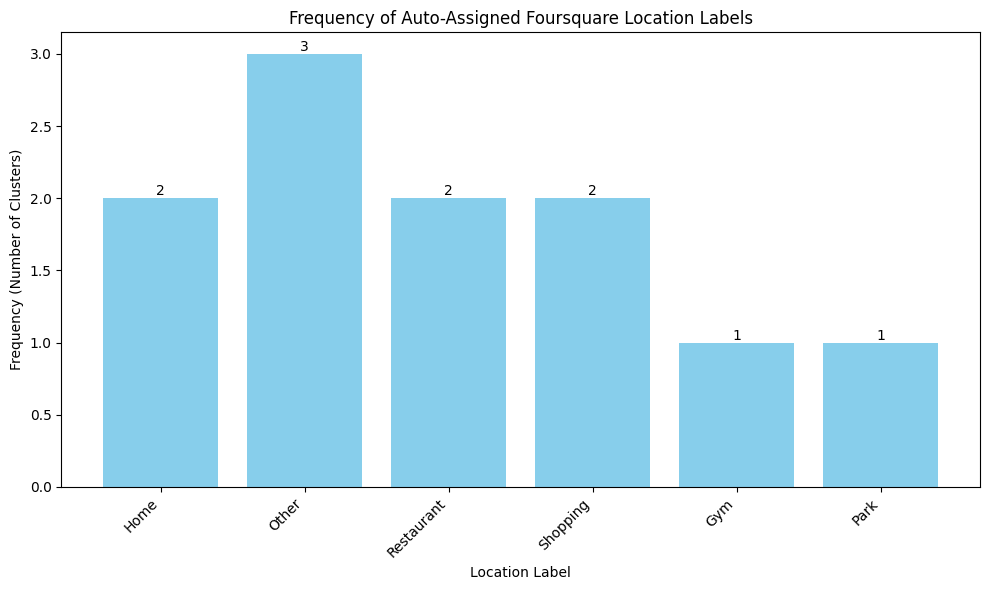

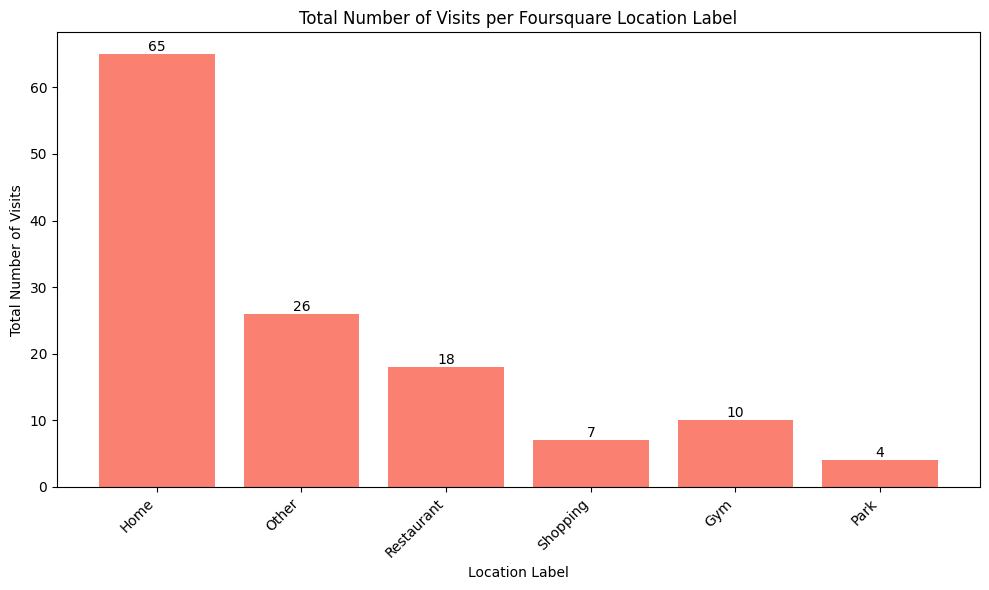

In [92]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

filtered_cluster_info = {
    0: {"centroid": (38.030823000000034, -78.50873700000007), "auto_label": "Home", "count": 47},
    1: {"centroid": (38.03355299999999, -78.507977), "auto_label": "Other", "count": 17},
    2: {"centroid": (38.055007999999994, -78.496939), "auto_label": "Restaurant", "count": 9},
    3: {"centroid": (38.032187, -78.493222), "auto_label": "Restaurant", "count": 9},
    4: {"centroid": (38.052815, -78.501257), "auto_label": "Shopping", "count": 4},
    5: {"centroid": (38.031619, -78.510846), "auto_label": "Other", "count": 5},
    6: {"centroid": (38.032882, -78.513558), "auto_label": "Gym", "count": 10},
    7: {"centroid": (37.687814, -77.602768), "auto_label": "Home", "count": 18},
    8: {"centroid": (37.656101, -77.618943), "auto_label": "Shopping", "count": 3},
    9: {"centroid": (37.668375, -77.612032), "auto_label": "Park", "count": 4},
    10: {"centroid": (37.650861500000005, -77.604527), "auto_label": "Other", "count": 4}
}

# Calculate frequency: number of clusters per label
label_freq = Counter(info["auto_label"] for info in filtered_cluster_info.values())

# Calculate total visits per label (summing the "count" for each label)
label_visits = defaultdict(int)
for info in filtered_cluster_info.values():
    label_visits[info["auto_label"]] += info["count"]

# Plot 1: Frequency of Auto-Assigned Foursquare Labels (Number of Clusters)
plt.figure(figsize=(10, 6))
plt.bar(label_freq.keys(), label_freq.values(), color='skyblue')
plt.xlabel("Location Label")
plt.ylabel("Frequency (Number of Clusters)")
plt.title("Frequency of Auto-Assigned Foursquare Location Labels")
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the frequency value
for label, count in label_freq.items():
    plt.text(label, count, f'{count}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot 2: Total Number of Visits per Label
plt.figure(figsize=(10, 6))
plt.bar(label_visits.keys(), label_visits.values(), color='salmon')
plt.xlabel("Location Label")
plt.ylabel("Total Number of Visits")
plt.title("Total Number of Visits per Foursquare Location Label")
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the number of visits
for label, total in label_visits.items():
    plt.text(label, total, f'{total}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
